# Eco Break Conditions

We can specify break conditions on our eco sends which, when met, force the simulator to stop eco'ing the current send and attempt to move on to the next send in the eco queue. In this tutorial document we utilize one such condition called `max_eco_amount` to determine optimal eco'ing during round 1 defense. We'll cover the following base cases from which the end user can develop further to optimize their strategies:

1. Standard tack start with Jericho
2. Perfect anti-stall tack start with Jericho
3. Standard dartling start with Jericho
4. Mortar start with Jericho

Let's begin by importing the b2 module.

In [1]:
import b2sim.engine as b2
import b2sim.analysis as dd

## More About Eco Sends

The eco queue, defined as a list of `b2.ecoSend(time = x, send_name = y)` calls, can be used to tell the simulator that at time $x$, you wish to eco with the send $y$. However, in some game scenarios, players may desire to stop eco or switch eco sends not at a predetermined time, but rather when a break condition of some sort is met, such as reaching a certain amount of eco. 

By the way, if you need a quick reference for *all* the things you can do in the simulator, take a look at `actions.py`. You'll notice that there are more arguments available for the `ecoSend` call that we haven't yet gone into detail about yet!

## Eco Numbers

When adding sends to the eco queue in the simulator, you can specify either a maximum eco amount `max_eco_amount` or a maximum send amount `max_send_amount`. 
1. If a value for `max_eco_amount` is specified, the simulator will attempt to switch to the next send in the eco queue (or the zero send if the queue is empty) once the max eco amount has been reached or exceeded.
2. If a value for `max_send_amount` is specified, the simulator will attempt to switch to the next send in the eco queue (or the zero send if the queue is empty) once the specified bloon send has been sent the specified number of times.

## The Power of Python

Since we're going to be doing the same thing multiple times over in this document --- in this case, determining eco numbers for multiple different compositions, let's build a function to automate the process and cut down on the overall amount of lines of code needed.

In [2]:
def eco_numbers(rounds, buy_queue, red_eco_limit = 273, blue_eco_limit = 279, filename = 'eco_numbers', view_stats = True):

    eco_queue = [
            b2.ecoSend(time = rounds.getTimeFromRound(1) + 0.5, send_name = 'Grouped Reds', max_eco_amount = red_eco_limit),
            b2.ecoSend(time = rounds.getTimeFromRound(2), send_name = 'Spaced Blues', max_eco_amount = blue_eco_limit)
    ]

    initial_state_game = {
        'Cash': 650,
        'Eco': 250,
        'Eco Send': b2.ecoSend(send_name='Zero'),
        'Rounds': rounds,
        'Game Round': 0,
        'Buy Queue': buy_queue,
        'Eco Queue': eco_queue
    }

    game_state = b2.GameState(initial_state_game)
    game_state.fastForward(target_round = 2)

    if view_stats:
        dd.viewHistory(game_state)
        print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))
        print(game_state.eco_queue)
    
    #Always write the log file! It's useful to look at
    b2.writeLog(game_state.logs, filename = filename)

    if len(game_state.buy_queue) == 0:
        print("Success! Afforded all our defense in time!")
        return True
    else:
        return False
        print("Failed! We missed our R1 defense!")
    

## Standard Tack Start With Jericho (Round 1 vs Round 2)

In the standard start, we get access to *5* eco ticks before round 2 starts, with those eco ticks occuring at times $6,12,18,24, 30$ respectively. For this example, I've decided to display the graphs so you can see exactly how our money evolves over time. However, for future examples, I'm just gonna run the code and return the result over whether we afford all our defense or not.

**Warning**: The in-game eco counter is known to round incorrectly. While this says to do blues to 274, the eco counter will actually show *273* if you exactly as the simulator prescribes below.

,Time,Type,Message
0,0.0,Eco,Change eco to Zero
1,6.0,Round,Round 1 start
2,6.0,Buy,Buy Tack
3,6.5,Eco,Change eco to Grouped Reds
4,16.9,Eco,Change eco to Spaced Blues
5,26.2,Eco,Change eco to Zero
6,30.0,Buy,Buy Jericho
7,31.1,Round,Round 2 start


The current cash and eco are (12.600000000000136,276.2000000000001)
[]
Success! Afforded all our defense in time!


True

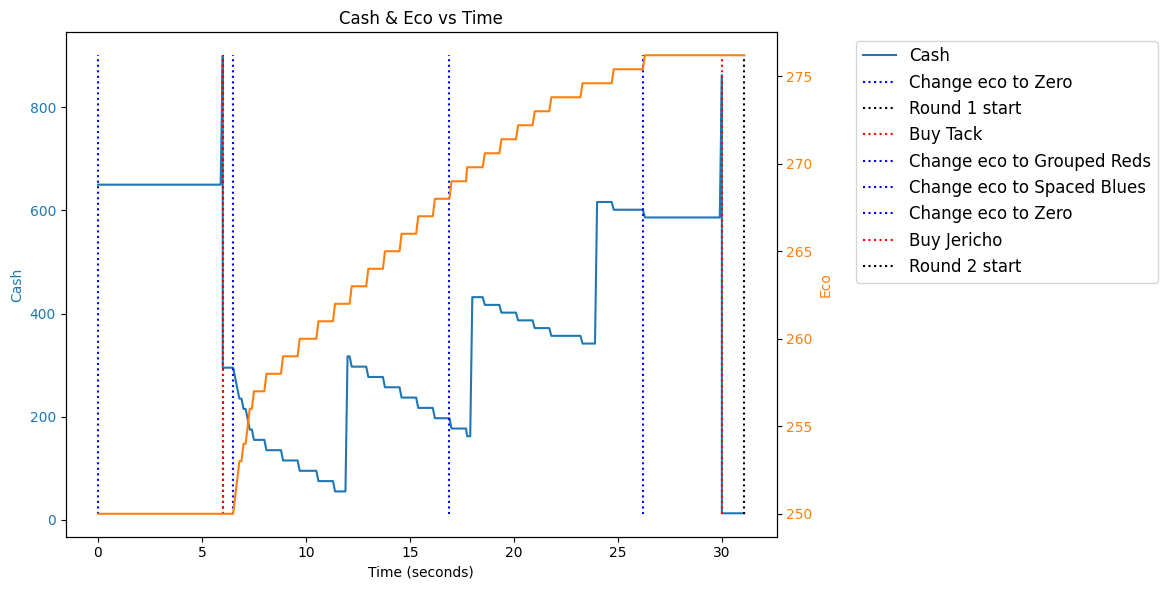

In [3]:
rounds = b2.Rounds(0.45)

buy_queue = [
    [b2.buyDefense(280 + 100 + 225, min_buy_time = rounds.getTimeFromRound(1), message = "Buy Tack")], #Buy 020 tack
    [b2.buyDefense(850, min_buy_time = rounds.getTimeFromRound(1.5), message = "Buy Jericho")] #Buy Jericho
]

eco_numbers(rounds, buy_queue = buy_queue, red_eco_limit = 269, blue_eco_limit = 276, filename='eco_numbers_1')

## Perfect Anti-Stall Tack Start with Jericho

If the game is perfectly anti-stalled, we will have access to one less eco tick than usual, meaning we have to adjust our strategy to get Jericho on R1. To compensate, we will not crosspath the tack and we will eco blues sooner before deciding to save for Jericho:

In [4]:
rounds = b2.Rounds(0.0)

buy_queue = [
    [b2.buyDefense(280 + 100 + 225, min_buy_time = rounds.getTimeFromRound(1), message = "Buy Tack")], #Buy 020 tack
    [b2.buyDefense(750, min_buy_time = rounds.getTimeFromRound(1.5), message = "Buy Jericho")] #Buy Jericho
]

eco_numbers(rounds, buy_queue = buy_queue, red_eco_limit = 263, blue_eco_limit = 267, filename='eco_numbers_2', view_stats = False)

Success! Afforded all our defense in time!


True

## Standard Dartling Start with Jericho

It is reasonable to expect in most dartling alch farm games that the player will have access to 5 eco ticks, especially if the opponent is *also* playing Dartling.

,Time,Type,Message
0,0.0,Eco,Change eco to Zero
1,6.0,Round,Round 1 start
2,8.6,Buy,Buy Dartling
3,24.0,Buy,Buy Jericho
4,31.1,Round,Round 2 start
5,31.1,Eco,Change eco to Spaced Blues


The current cash and eco are (250,250)
[]
Success! Afforded all our defense in time!


True

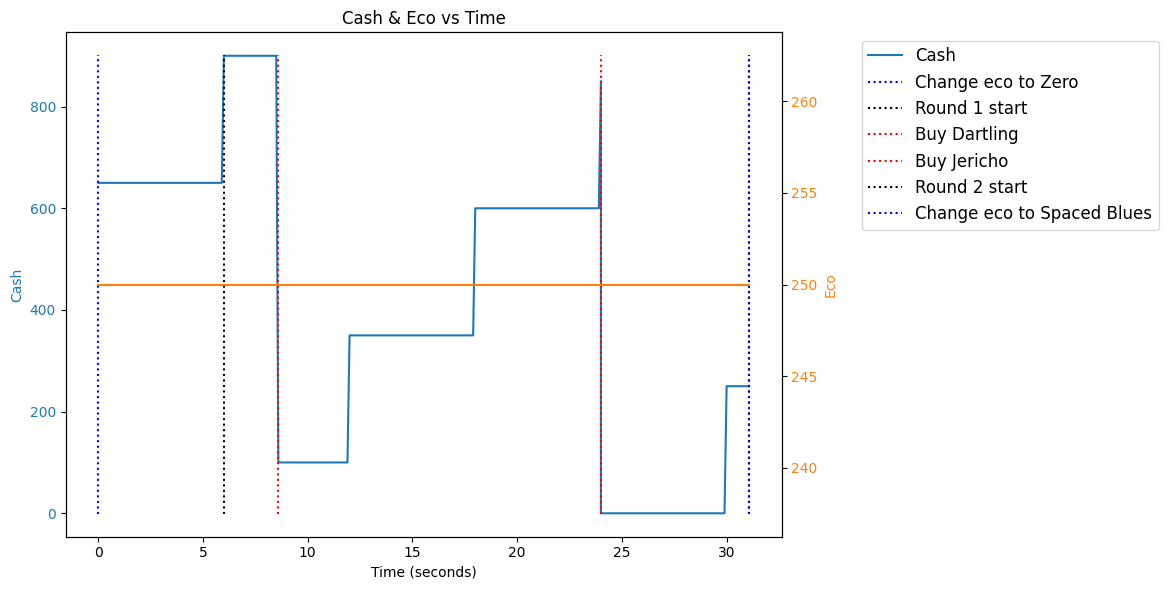

In [5]:
rounds = b2.Rounds(0.45)

buy_queue = [
    [b2.buyDefense(800, min_buy_time = rounds.getTimeFromRound(1.1), message = "Buy Dartling")], #Buy 000 dartling
    [b2.buyDefense(850, min_buy_time = rounds.getTimeFromRound(1.5), message = "Buy Jericho")] #Buy Jericho
]

eco_numbers(rounds, buy_queue = buy_queue, red_eco_limit = 249, blue_eco_limit = 266, filename='eco_numbers_3', view_stats = True)

## Mortar Start With Jericho

In [6]:
rounds = b2.Rounds(0.45)

buy_queue = [
    [b2.buyDefense(700, min_buy_time = rounds.getTimeFromRound(1.2), message = "Buy Dartling")], #Buy 000 mortar
    [b2.buyDefense(850, min_buy_time = rounds.getTimeFromRound(1.5), message = "Buy Jericho")] #Buy Jericho
]

eco_numbers(rounds, buy_queue = buy_queue, red_eco_limit = 265, blue_eco_limit = 271, filename='eco_numbers_3', view_stats = False)

Success! Afforded all our defense in time!


True